In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
# load dataset 'movies' and 'ratings'
df_movie = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv')

In [3]:
# merge dataset by 'movieId' column
df = pd.merge(df_movie, df_ratings, on='movieId')
    
    

In [4]:
# check for null values
df.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [5]:
# check for duplicates
df.duplicated().sum()

0

In [7]:
# Find unique users
unique_users = df['userId'].unique()
print("Unique Users:", len(unique_users))

# Find unique movies
unique_movies = df['movieId'].unique()
print("Unique Movies:", len(unique_movies))

Unique Users: 668
Unique Movies: 10325


In [6]:
# # Unique movies
unique_movies = df_movie['title'].str.split('|', expand=True).stack().unique()
print(unique_movies)

['Toy Story (1995)' 'Jumanji (1995)' 'Grumpier Old Men (1995)' ...
 'A Very Murray Christmas (2015)' 'The Big Short (2015)'
 'Marco Polo: One Hundred Eyes (2015)']


In [8]:
# 1.popularity based recommendation 

# inputes by user ' genre','threshold ratings'and 'number of recommendetion'
genre=str(input('enter genre:'))
min_reviews_threshold =int(input('enter  min_threshold ratings:')) 
num_recommendations =int(input('no of recommndetion:'))


# filter movies by 'genres'
genre_movies = df[df['genres'].str.contains(genre, case=False)]

# calculate avrage rating and no of reviws to movie
movie_stats = genre_movies.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'num_reviews']

# filter movies by threshold no of revies
filtered_movies = movie_stats[movie_stats['num_reviews'] >= min_reviews_threshold]

# sorting of movies by average rating in descending order
sorted_movies = filtered_movies.sort_values('avg_rating', ascending=False)

# recommendetion
recommendations = sorted_movies.head(num_recommendations)
recommended_movies = pd.merge(recommendations,df_movie, on='movieId')
recommended_movies.reset_index(drop=True, inplace=True)
recommended_movies.index += 1
recommended_movies = recommended_movies.rename(columns={'index': 'S.No'})
recommended_movies = recommended_movies[['title', 'avg_rating', 'num_reviews']]

# display recommended movies
print(recommended_movies)

enter genre:Action
enter  min_threshold ratings:200
no of recommndetion:5
                                               title  avg_rating  num_reviews
1                                 Matrix, The (1999)    4.264368          261
2  Star Wars: Episode V - The Empire Strikes Back...    4.228070          228
3  Raiders of the Lost Ark (Indiana Jones and the...    4.212054          224
4          Star Wars: Episode IV - A New Hope (1977)    4.188645          273
5                                  Fight Club (1999)    4.188406          207


In [9]:
# 2.content based recommendetion

# inpute by user
movie_title= str(input('enter title of movie :'))
num_recommendations = int(input('enter number of recommendetion required :'))

# define function for content based recommendetion 
def content_based_recommender(movie_title, num_recommendations):
    # Select the movie for which you want to find similar movies
    selected_movie = df_movie[df_movie['title'] == movie_title]
    
    # Check if the selected_movie DataFrame is empty
    if selected_movie.empty:
        print("Movie not found in the dataset.")
        return []
    
    # Retrieve the genres of the selected movie
    selected_movie_genres = selected_movie['genres'].values[0].split('|')
    
    # Calculate similarity scores with other movies based on genre overlap
    similarity_scores = []
    for index, row in df_movie.iterrows():
        movie_genres = row['genres'].split('|')
        similarity_score = len(set(selected_movie_genres) & set(movie_genres))
        similarity_scores.append((row['title'], similarity_score))
    
    # Sort movies based on similarity scores
    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Select top N movies as recommendations
    top_movies = similarity_scores[:num_recommendations]
    
    return top_movies




recommendations = content_based_recommender(movie_title, num_recommendations)

# display movies based on content
if len(recommendations) == 0:
    print("No recommendations found.")
else:
    print("Top", num_recommendations, "movies similar to", movie_title+":")
    for rank, (movie, score) in enumerate(recommendations, start=1):
        print(rank, movie)

enter title of movie :Fugitive, The (1993)
enter number of recommendetion required :6
Top 6 movies similar to Fugitive, The (1993):
1 Heat (1995)
2 GoldenEye (1995)
3 Money Train (1995)
4 Get Shorty (1995)
5 Copycat (1995)
6 Assassins (1995)


In [10]:
# 3.collaborative based recommender system

# input by user
target_user =int(input('userId : '))
num_recommended=int(input('no of recommendation (n): '))
similar_user_threshold=int(input('threshold (k): '))

# filter rating by target user('userId')
target_user_rating =df_ratings[df_ratings['userId']==target_user]
target_user_rating.head()

# calculate similarity
user_ratings =df_ratings.pivot(index='userId',columns='movieId',values='rating').fillna(0)
user_similarity = cosine_similarity(user_ratings)

# get k similar
similar_user_indices =user_similarity[target_user-1].argsort()[::-1][1:similar_user_threshold+1]

# movie rated by similar user
similar_user_rating = user_ratings.iloc[similar_user_indices]
similar_user_movie = similar_user_rating.columns[user_ratings.loc[target_user]==0]

# movie recommendetion
recommended = pd.DataFrame(similar_user_rating[similar_user_movie].mean().sort_values(ascending=False))
recommended.columns=['average_ratings']
recommended.index_name ='movieId'
recommendetion= pd.merge(recommended,df_movie,on='movieId').head(num_recommended)

#display
print('recommended movies')
for i, row in recommendetion.iterrows():
    print(f"{i+1}. {row['title']}")




userId : 15
no of recommendation (n): 5
threshold (k): 150
recommended movies
1. Matrix, The (1999)
2. Shawshank Redemption, The (1994)
3. American Beauty (1999)
4. Star Wars: Episode IV - A New Hope (1977)
5. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)


C:\Users\amitt\miniconda3\lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [ ]:
# Exploratory Data Analysis including:
#     Understanding of distribution of the features availableo
#     Finding unique users and movieso
#     Average rating and Total movies at genre level.
#     Unique genres considered.

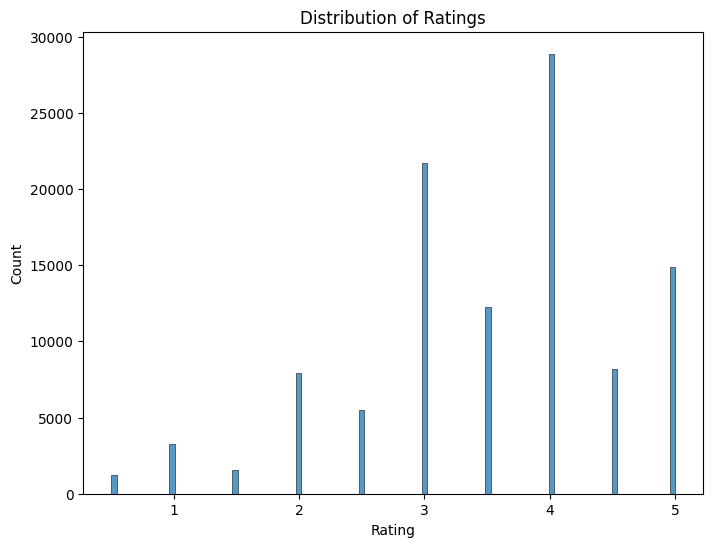

In [11]:
# distribution of ratings

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


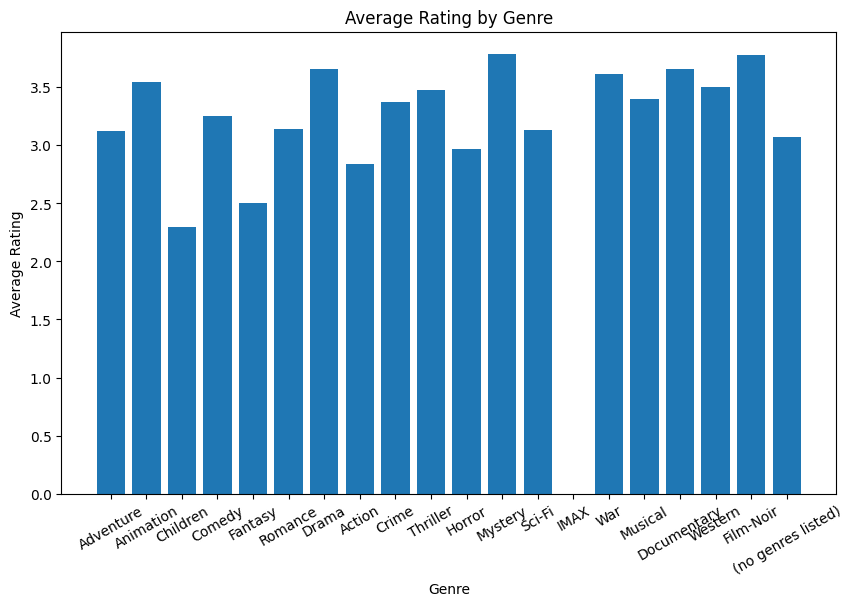

In [12]:
def calculate_average_rating(genre):
# Filter movies based on genre
    filtered_movies = df[df['genres'] == genre]
    
    # Calculate average rating
    average_rating = filtered_movies['rating'].mean()
    
    return average_rating

# Get unique genres

unique_genres = df_movie['genres'].str.split('|', expand=True).stack().unique()

# Calculate average ratings for each genre

average_ratings = [calculate_average_rating(genre) for genre in unique_genres]

# Plotting average rating with respect to genres

plt.figure(figsize=(10, 6))
plt.bar(unique_genres, average_ratings)
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Rating by Genre')
plt.xticks(rotation=30)
plt.show()


In [13]:
# Find unique users
unique_users = df['userId'].unique()
print("Unique Users:", len(unique_users))

# Find unique movies
unique_movies = df['movieId'].unique()
print("Unique Movies:", len(unique_movies))

Unique Users: 668
Unique Movies: 10325


In [14]:
# calculate average rating with respect to 'Genres' and number of movies of genres

def calculate_average_rating(genre):
    # Filter movies based on genre
    filtered_movies = df[df['genres'] == genre]
    
    # Calculate average rating
    average_rating = filtered_movies ['rating'].mean()
    
    return average_rating

def count_movies(genre):
    # Filter movies based on genre
    filtered_movies = df[df['genres'] == genre]
    
    # Count total number of movies
    total_movies = filtered_movies.shape[0]
    
    return total_movies

# Genre enter by user

genre= str(input('enter genre:'))

average_rating = calculate_average_rating(genre)
total_movies = count_movies(genre)

# display

print("Genre:", genre)
print("Average Rating:", average_rating)
print("Total Movies:", total_movies)


enter genre:Drama
Genre: Drama
Average Rating: 3.655965095076843
Total Movies: 7678


In [15]:
# Unique genres considered
unique_genres = df_movie['genres'].str.split('|', expand=True).stack().unique()
print("Unique Genres Considered:")
print(unique_genres)

Unique Genres Considered:
['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX' 'War'
 'Musical' 'Documentary' 'Western' 'Film-Noir' '(no genres listed)']
